In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
df = pd.read_csv('frauddetec.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig','newbalanceOrig':'newBalanceOrig',
                        'oldbalanceDest':'oldBalanceDest','newbalanceDest':'newBalanceDest'})
print(df.head())

   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [5]:
df.isnull().values.any()

False

## we can see that there are only two type (TRANSFER and CASH_OUT) which cause fraudulent transactions ##

In [6]:
list(df.loc[df.isFraud==1].type.drop_duplicates().values)

['TRANSFER', 'CASH_OUT']

In [7]:
dfFraudTransfer = df.loc[(df.isFraud==1) & (df.type=='TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud==1) & (df.type=='CASH_OUT')]
print('The number of fraudulent transfers:', len(dfFraudTransfer))
print('The number of fraudulent cashout:', len(dfFraudCashout))

The number of fraudulent transfers: 4097
The number of fraudulent cashout: 4116


## only transfer type cause flagged fraud ##
## IsFlaggedFraud can remain not set although the condition (amount > 200,000) being met ##

In [8]:
print('The type of transactions in which isFlaggedFraud is set:', 
      list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates().values))
dfTransfer = df.loc[df.type =='TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud==1]
dfNotFlagged = df.loc[df.isFlaggedFraud==0]
print('Minimun amount transacted when isFlaggedFraud is set:', (dfFlagged.amount.min()))
print('Maximum amount transacted in a TRANSFER wher is FlaggedFraud is not set:', (dfNotFlagged.amount.max()))

The type of transactions in which isFlaggedFraud is set: ['TRANSFER']
Minimun amount transacted when isFlaggedFraud is set: 353874.22
Maximum amount transacted in a TRANSFER wher is FlaggedFraud is not set: 92445516.64


## oldBalanceDest and newBalanceDest do not determine the state of isFlaggedFraud ##

In [9]:
print('The number of TRANSFERs where isFlaggedFraud = 0, oldBalanceDest = 0, and newBalanceDest = 0 :', 
      len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceDest==0) & (dfTransfer.newBalanceDest==0)]))

The number of TRANSFERs where isFlaggedFraud = 0, oldBalanceDest = 0, and newBalanceDest = 0 : 4158


## there are few number of being destination accounts more than once ##

In [10]:
print('Originators of transactions flagged as fraud transacted have more than once is : ',
      dfFlagged.nameOrig.isin(pd.concat([dfNotFlagged.nameOrig, dfNotFlagged.nameDest])).any())
print('Destinations for transactions flagged as fraud transacted have initiated other transactions is : ',
     dfFlagged.nameDest.isin(dfNotFlagged.nameOrig).any())
print('The number of destination accounts of transactions flagged as fraud have been destination accounts more than once are : ',
      sum(dfFlagged.nameDest.isin(dfNotFlagged.nameDest)))

Originators of transactions flagged as fraud transacted have more than once is :  False
Destinations for transactions flagged as fraud transacted have initiated other transactions is :  False
The number of destination accounts of transactions flagged as fraud have been destination accounts more than once are :  2


In [13]:
print('Min, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: {}'.\
format([round(dfFlagged.oldBalanceOrig.min()), round(dfFlagged.oldBalanceOrig.max())]))
print('Min, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where \
oldBalanceOrig = \
newBalanceOrig: {}'.format(\
[dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
== dfTransfer.newBalanceOrig)].oldBalanceOrig.min(), \
round(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
               == dfTransfer.newBalanceOrig)].oldBalanceOrig.max())]))

Min, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: [353874, 19585040]
Min, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where oldBalanceOrig = newBalanceOrig: [0.0, 575668]


In [18]:
print('Are there any merchants among originator accounts for CASH_IN \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M')).any()))
print('Are there any merchants among destination accounts for CASH_OUT \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M')).any()))

Are there any merchants among originator accounts for CASH_IN transactions? False
Are there any merchants among destination accounts for CASH_OUT transactions? False


In [20]:
print('Within fraudulent transactions, are there destinations for TRANSFERS \
that are also originators for CASH_OUTs? {}'.format(\
(dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any())) # False
dfNotFraud = df.loc[df.isFraud == 0]

Within fraudulent transactions, are there destinations for TRANSFERS that are also originators for CASH_OUTs? False


## There are 3 accounts flagged as fraudulent in transfer but are originator labeled as geniune in Cash out

In [30]:
print('Fraudulent TRANSFERs whose destination accounts are originators of \
genuine CASH_OUTs: \n\n{}'.format(dfFraudTransfer.loc[dfFraudTransfer.nameDest.\
isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))

Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: 

         step      type      amount     nameOrig  oldBalanceOrig  \
1030443    65  TRANSFER  1282971.57  C1175896731      1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649       214793.32   
6362556   738  TRANSFER   814689.88  C2029041842       814689.88   

         newBalanceOrig     nameDest  oldBalanceDest  newBalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  


## 2 out of 3 of these accounts make a geniune CASH OUT then later received a fraudulent TRANSFER. Therefore, fraudulent transfer are not indicated by nameOrig and nameDest features. ##

In [35]:
print('Fraudulent TRANSFER to C423543548 occured at step = 65 whereas \
genuine CASH_OUT from this account occured earlier at step = \n{}'.format(\
dfNotFraud.loc[(dfNotFraud.type == 'CASH_OUT') & (dfNotFraud.nameOrig == \
                           'C1714931087')].step.values))
print('Fraudulent TRANSFER to C423543548 occured at step = 486 whereas \
genuine CASH_OUT from this account occured earlier at step = \n{}'.format(\
dfNotFraud.loc[(dfNotFraud.type == 'CASH_OUT') & (dfNotFraud.nameOrig == \
                           'C423543548')].step.values))
print('Fraudulent TRANSFER to C423543548 occured at step = 738 whereas \
genuine CASH_OUT from this account occured earlier at step = \n{}'.format(\
dfNotFraud.loc[(dfNotFraud.type == 'CASH_OUT') & (dfNotFraud.nameOrig == \
                           'C1023330867')].step.values))

Fraudulent TRANSFER to C423543548 occured at step = 65 whereas genuine CASH_OUT from this account occured earlier at step = 
[546]
Fraudulent TRANSFER to C423543548 occured at step = 486 whereas genuine CASH_OUT from this account occured earlier at step = 
[185]
Fraudulent TRANSFER to C423543548 occured at step = 738 whereas genuine CASH_OUT from this account occured earlier at step = 
[132]


In [40]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

In [46]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('The fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('The fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))

The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072
The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


In [47]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = - 1

In [50]:
X

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
2,1,0,181.00,181.00,0.0,-1.00,-1.00
3,1,1,181.00,181.00,0.0,21182.00,0.00
15,1,1,229133.94,15325.00,0.0,5083.00,51513.44
19,1,0,215310.30,705.00,0.0,22425.00,0.00
24,1,0,311685.89,10835.00,0.0,6267.00,2719172.89
...,...,...,...,...,...,...,...
6362615,743,1,339682.13,339682.13,0.0,0.00,339682.13
6362616,743,0,6311409.28,6311409.28,0.0,-1.00,-1.00
6362617,743,1,6311409.28,6311409.28,0.0,68488.84,6379898.11
6362618,743,0,850002.52,850002.52,0.0,-1.00,-1.00


In [51]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

In [56]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.00,0.0,-1.00,-1.00,0.00,1.810000e+02
3,1,1,181.00,181.00,0.0,21182.00,0.00,0.00,2.136300e+04
15,1,1,229133.94,15325.00,0.0,5083.00,51513.44,213808.94,1.827035e+05
19,1,0,215310.30,705.00,0.0,22425.00,0.00,214605.30,2.377353e+05
24,1,0,311685.89,10835.00,0.0,6267.00,2719172.89,300850.89,-2.401220e+06
...,...,...,...,...,...,...,...,...,...
6362615,743,1,339682.13,339682.13,0.0,0.00,339682.13,0.00,0.000000e+00
6362616,743,0,6311409.28,6311409.28,0.0,-1.00,-1.00,0.00,6.311409e+06
6362617,743,1,6311409.28,6311409.28,0.0,68488.84,6379898.11,0.00,1.000000e-02
6362618,743,0,850002.52,850002.52,0.0,-1.00,-1.00,0.00,8.500025e+05


In [58]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

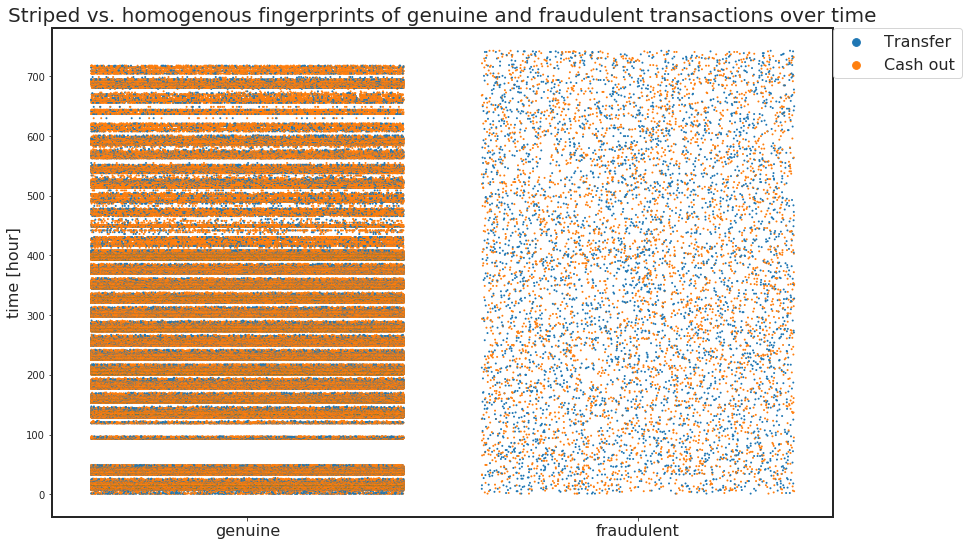

In [59]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 20);

Text(0.5, 1.0, 'Same-signed fingerprints of genuine and fraudulent transactions over amount')

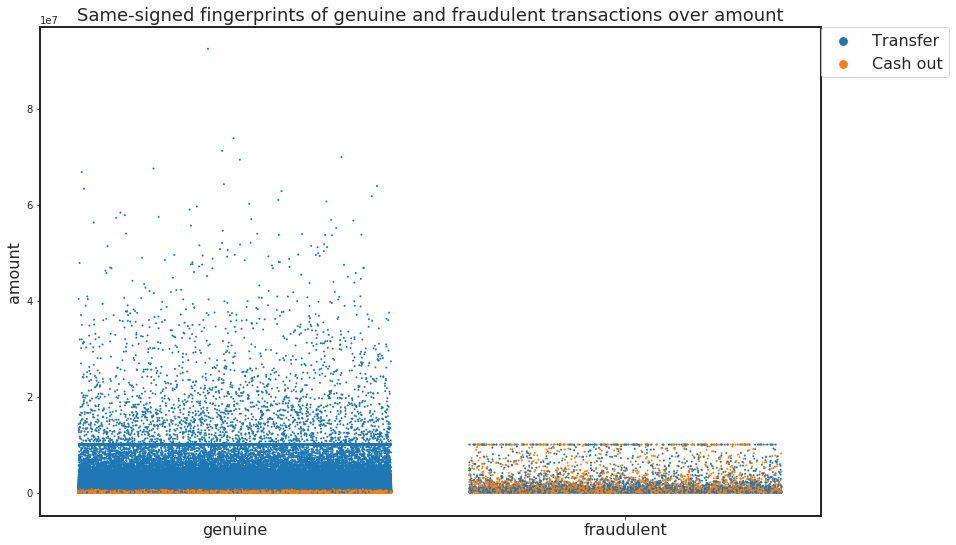

In [64]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18)

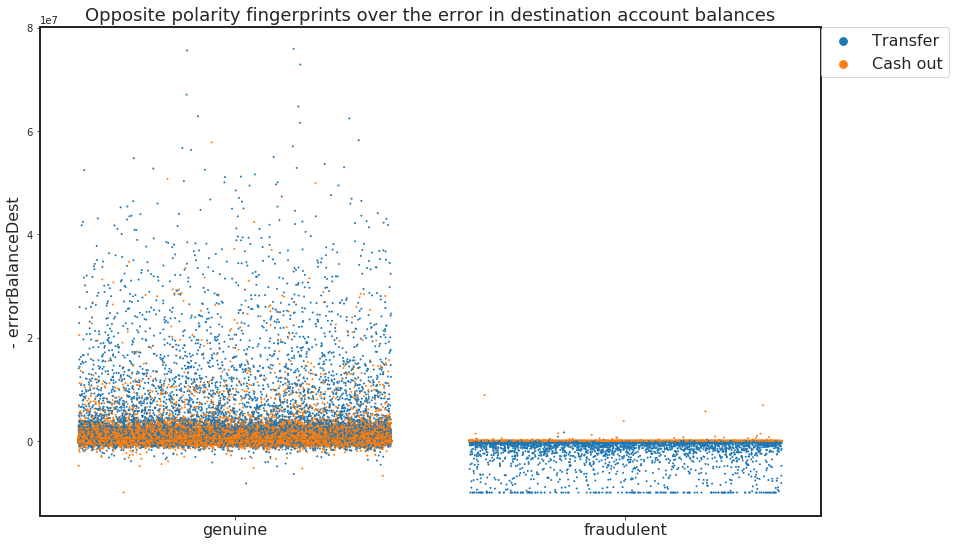

In [67]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);

C:\Users\ASUS\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
C:\Users\ASUS\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\ASUS\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
C:\Users\ASUS\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\ASUS\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in 

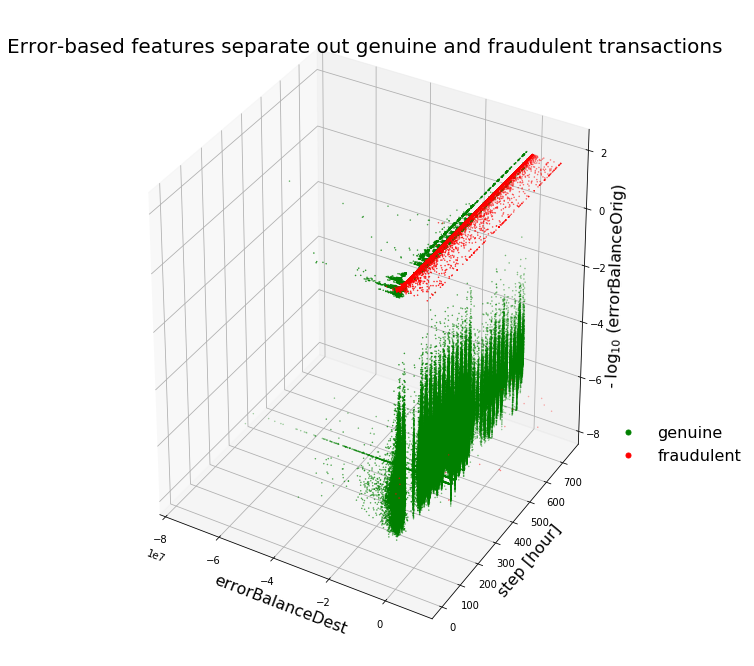

In [68]:
# Long computation in this cell (~2.5 minutes)
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

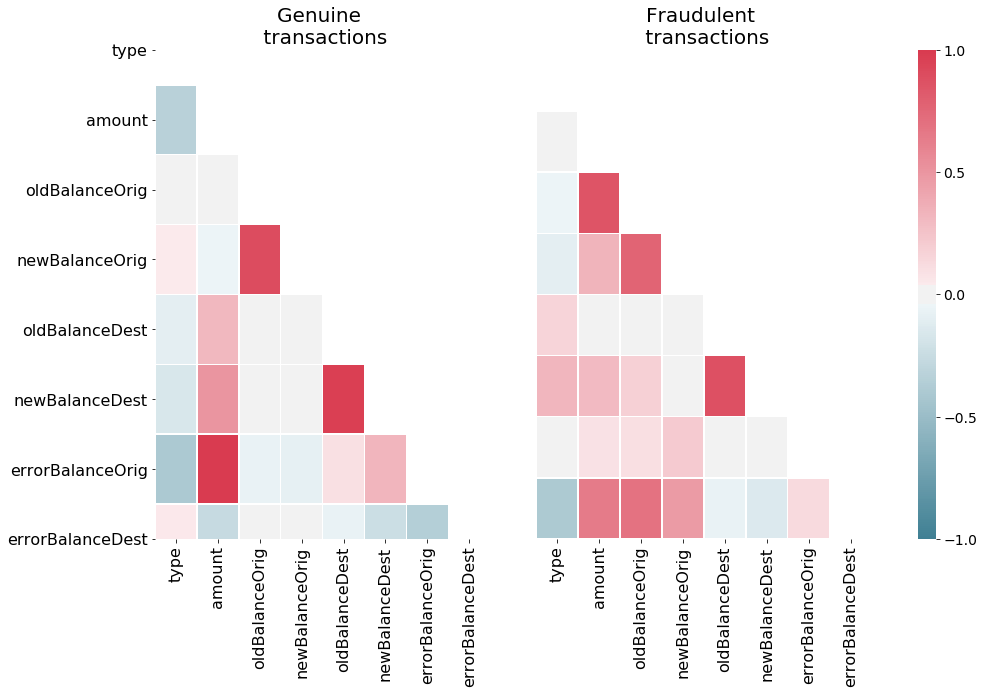

In [69]:
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);

In [70]:
print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.002964544224336551


In [71]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

In [75]:
# Long computation in this cell (~1.8 minutes)
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

AUPRC = 0.9983642588456605


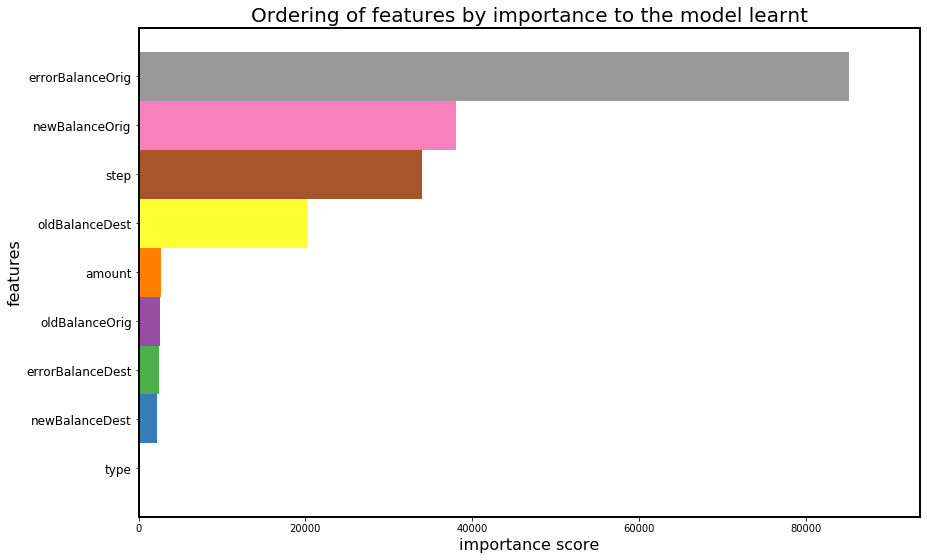

In [76]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

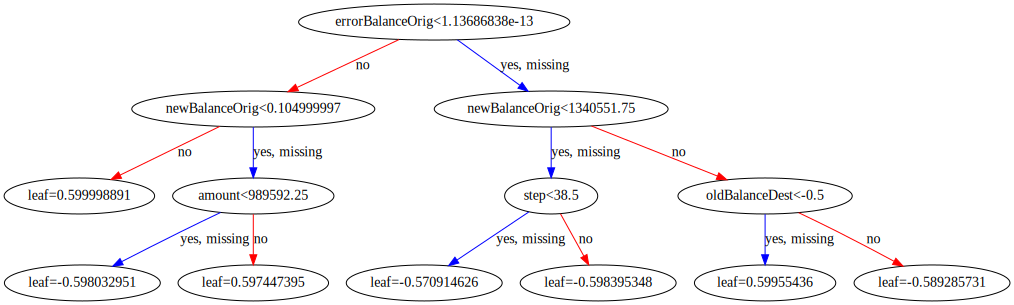

In [77]:
to_graphviz(clf)

In [78]:
# Long computation in this cell (~6 minutes)

trainSizes, trainScores, crossValScores = learning_curve(\
XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4), trainX,\
                                         trainY, scoring = 'average_precision')

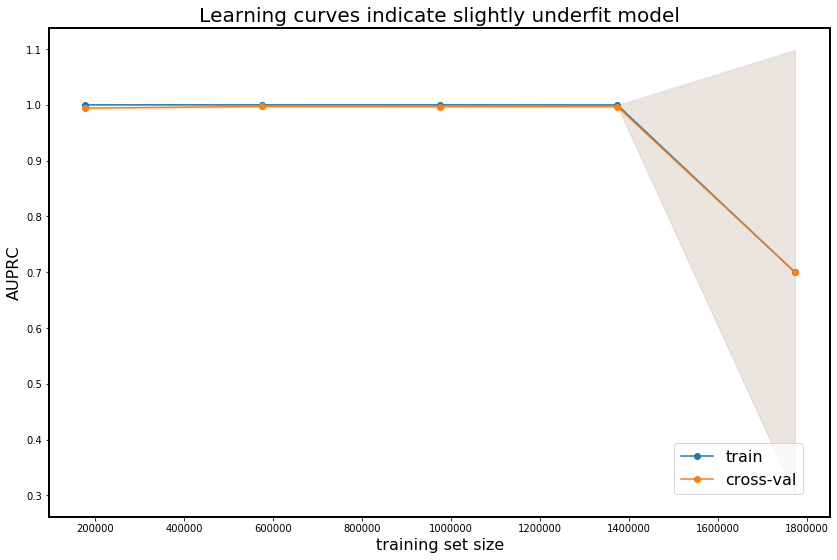

In [79]:
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
    trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
    crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', \
         color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', \
         color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), \
               loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);